# Accesibilidad rural en Asturias

Este documento explica cómo calcular la accesibilidad rural a hospitales, y otros proveedores de servicios básicos, como bancos o supermercados.

Permite responder a preguntas como:
* ¿Qué porcentaje de asturianos puede no llega, conduciendo, a su hospital más cercano en 1 hora?
* ¿Cómo favorece la mejora de cierta carretera en el acceso más rápido a servicios básicos?
* ¿Qué pasa si cierta carretera queda bloqueada?

Para responder a estas preguntas, sólo hacer falta usar software y datos libre, en concreto:
* [Open Street Map](http://osm.org). Mapa de datos libres, de donde sacamos las carreteras. Es posible conseguir los datos de carreteras oficiales del [Instituto Geográfico Nacional](http://www.ign.es/web/ign/portal), pero el programa que usaremos para obtener los tiempos de conducción usa una nomenclatura de tipos de carretera diferente.
* [Open Street Routing Map](http://osrm.org). Programa de enrutado. Utilizando como base los datos y nomenclatura de OSM es capaz de calcular la ruta más rápida según el tipo de transporte (andando, coche, bici, ...) y la velocidad típica de cada tipo de carretera (autopista, nacional, pavimentada, caleya, ...)
* [Python](). Usamos el lenguaje de programación python, y una serie de librerías dentro de ésta, para calcular todos los datos de accesibilidad.

## Obtener datos OSM

Este paso descarga todas las carreteras de Asturias, y una abudante franja alrededor (para incluir casos donde la mejor ruta para llegar desde algún punto de Asturias a otro incluye salir temporalmente a otra provincia.

### Instalar software

Además de python y jupyter para poder correr este documento, hacen falta un par de utilidades:
* osmconvert:
 `wget -O - http://m.m.i24.cc/osmconvert.c | cc -x c - -lz -O3 -o osmconvert`
* osmupdate
`wget -O - http://m.m.i24.cc/osmupdate.c | cc -x c - -o osmupdate`
* [Gdal](http://www.gdal.org/)
* [docker](https://docs.docker.com/install/)

### 1. Descargar los datos de Asturias


Lo más facil es hacer un rectángulo que abarque todo asturias y un poco de Galicia, León y Cantabria. Lo suficiente para incluir las autopistas que quizás sea mejor usar en algunos casos cuando vamos de un sitio a otro de Asturias, e incluir los hospitales que puedan estar más cerca de la gente que vive cerca de la frontera.


[![](asturias-roi.png)](https://gist.github.com/brunosan/d6be05f3a58136fe7c0e816c684235f0)

En `bash` se puede descargar todo el OSM de esta región facilmente:

```sh
    wget https://gist.githubusercontent.com/brunosan/d6be05f3a58136fe7c0e816c684235f0/raw/03386f6f8734320f2bca8d46a4386109afcd0488/map.geojson
   ogrinfo map.geojson map | grep Extent
   BBOX="-7.822265625000001,42.69858589169842,-3.8671874999999996,43.6599240747891"

   #Download the latest OSM data:
   DATE=`date '+%Y-%m-%d'`
   mkdir data/
   cd data/
   wget -P data/ -O asturias_$DATE.osm "http://overpass.osm.rambler.ru/cgi/xapi_meta?*[bbox=$BBOX
```

**Opcionalmente** Si espacio en disco es un problema, podemos convertir el archivo `.osm` al formato `.o5m`, que en este caso reduce el tamaño de ~1 Gb a ~100 Mb. 

```sh
../osmconvert -v asturias_$DATE.osm -o=asturias_$DATE.o5m
```

**Actualizar**. OSM se actualiza constantemente. Si queremos actualizar a la última versión, en vez de descargar todos los datos de nuevo, podemos usar este comando para obtener sólo los cambios. Mucho más rápido.

```sh
../osmupdate -v asturias_$DATE.o5m asturias_$DATE_tmp.o5m -b=$BBOX
```

### 2. Correr el enrutador

Para obtener el tiempo de viaje, en coche por ejemplo, entre cualquier par de puntos, necesitamos saber cual es la ruta más rápida. Para esto usamos el enrutador [OSRM](https://github.com/Project-OSRM/osrm-backend), con un perfil de coche.

La elección del tipo de transporte es importante porque especifica qué tipo de carreteras puede usar (por ejemplo elimina los caminos peatonales, las vías de tren, ... Además, asigna velocidades típicas en función del tipo de vía o tipo de asfalto que figure en las propiedades del archivo de OSM. Por esto llevaría mucho más tiempo usar los archivos de vías oficiales, ya que el diccionario de tipos de vías y pavimento no es el mismo que OSM; y OSRM está diseñado para usar OSM.

Con `docker` instalado, instalar y correr el enrutador son 3 líneas:

```sh
#transformar los datos de OSM, con el perfil de coche
docker run -t -v $(pwd):/data osrm/osrm-backend osrm-extract -p /opt/car.lua /data/asturias_2018-03-30.o5m
docker run -t -v $(pwd):/data osrm/osrm-backend osrm-partition /data/asturias_2018-03-30.o5m.osrm
docker run -t -v $(pwd):/data osrm/osrm-backend osrm-customize /data/asturias_2018-03-30.o5m.osrm

#Correr el servicio de rutas localmente
docker run -t -i -p 5000:5000 -v $(pwd):/data osrm/osrm-backend osrm-routed --algorithm mld /data/asturias_2018-03-30.o5m.osrm
```

Aunque el servicio ya está funcionando, también es posible usar un visualizador usual, que en este caso, funciona localmente en [http://127.0.0.1:9966](http://127.0.0.1:9966)
```sh
docker run -p 9966:9966 osrm/osrm-frontend
```

[![](ruta.png)](http://127.0.0.1:9966/?z=11&center=43.482072%2C-5.717010&loc=43.394020%2C-5.706718&loc=43.523757%2C-6.047233&hl=en&alt=0)

**EXTRA**

OSRM es una herramienta extremadamente compleja, con muchas funcionalidades muy sencillas de usar. Una de ellas es crear una visualización de la velocidad de ruta de cada tramo de carretera, giro y paso. Además, indica --en rosa-- los tramos de carretera que no están conectados a la red general, por ejemplo por un error al introducir las trazas en OSM.

Para explorar esta vista sólo hay que visitar `http://127.0.0.1:9966/debug/`

[![](debug.png)](http://127.0.0.1:9966/debug/?z=11&center=43.482072%2C-5.717010&loc=43.394020%2C-5.706718&loc=43.523757%2C-6.047233&hl=en&alt=0#16.87/43.39366/-5.80220)


In [1]:
osrm_server="http://0.0.0.0:5000"
#osrm_server="https://router.project-osrm.org" #Use a OSM-based, global, car, osrm server"


In [2]:
#Hacer una llamada sencilla entre 2 puntos

import requests  #http framework to make Mapbox API requests for routes
import json # handle response as json
import datetime # save timestamp

url=osrm_server+"/route/v1/driving/"
comma="%2C"
sep="%3B"

origin=[43.394020,-5.706718]
destination=[43.523757,-6.047233]
fullurl=url+str(origin[1])+','+str(origin[0])+";"+str(destination[1])+','+str(destination[0])
response = requests.get(fullurl) #do the request
response.raise_for_status() # ensure we notice bad responses
print, fullurl
# http://localhost:5000/route/v1/driving/-17.418823,14.721761;-13.95813,13.480448'
print("Entre La Corrada y Noreña hay %2.1f km y ~%2.0f minutos en coche"%
      (json.loads(response.text)['routes'][0]['distance']/1000.,
       json.loads(response.text)['routes'][0]['duration']/60.))
#Entre La Corrada y Noreña hay 48.8 km y ~37 minutos en coche


Entre La Corrada y Noreña hay 48.8 km y ~37 minutos en coche


### Descargar todas los municipios de Asturias, y su población

El [Instituto Geográfico Nacional](http://www.ign.es/web/ign/portal) tiene un fichero `BD_Municipios-Entidades` que contiene una base de datos de todas las ["Entidades"](https://es.wikipedia.org/wiki/Entidad_singular_de_poblaci%C3%B3n) (ciudades, pueblos, aldeas, ...). El archivo incluye, entre otros, los campos que necesitamos (nombre, localización geográfica y población). El formato es `.obd` pero se puede transformar en `.geojson` (con LibreOffice para pasarlo a `.csv`, y Qgis para pasarlo a `.geojson`) con el que podemos trabajar más facilmente. Por conveniencia he subido los archivos transformados a este [gist](https://gist.github.com/brunosan/f52b12ccf7dfba0158b81646fcc7531c)

In [3]:
#descargar archivo si no existe
import sys
import os
import urllib

#carpeta
directory='./data/BD_Municipios-Entidades/'
if not os.path.exists(directory):
    os.makedirs(directory)

file='entidades_asturias.geojson'
url='https://gist.githubusercontent.com/brunosan/f52b12ccf7dfba0158b81646fcc7531c/raw/e20cd38f1d6cf1e803d27a2447f4e5610f48d9dc/entidades_asturias.geojson'
if not os.path.exists(directory+file):
    print("Descargando fichero desde gist.github")
    urllib.request.urlretrieve (url,directory+file)

## Calidad del enrutado

Antes de empezar a calcular accesibilidad, podemos comprobar la calidad de los datos y el enrutado. En particular:
* Quitar lugares que no tienen asignada una ubicación
* Quitar lugar sin gente
* Comprobar que nuestro enrutador llega a todas las poblaciones.

In [4]:
import geopandas as gpd

fname = "./data/BD_Municipios-Entidades/entidades_asturias.geojson"

df = gpd.read_file(fname)

df

,CODIGOINE,NOMBRE,COD_PROV,PROVINCIA,TIPO,POBLACION,INEMUNI,HOJA_MTN25,lon,lat,orlatlon,ALTITUD,oraltitud,sup,dis,geometry
0,33001000000,Allande,33,Asturias,Municipio,1742,33001,0050-2,-6.608383,43.272294,Mapa,524,MDT5,FALSO,FALSO,POINT (-6.60838301 43.27229373)
1,33001010000,Berducedo,33,Asturias,Entidad colectiva,134,33001,0050-3,-6.767586,43.232347,Mapa,899,MDT5,FALSO,FALSO,POINT (-6.76758642 43.23234691)
2,33001010100,Baldedo,33,Asturias,Entidad singular,4,33001,0050-3,-6.767333,43.247713,Mapa,856,MDT5,FALSO,FALSO,POINT (-6.76733326 43.24771251)
3,33001010199,Baldedo,33,Asturias,Diseminado,4,33001,0050-3,-6.767333,43.247713,Mapa,856,MDT5,FALSO,FALSO,POINT (-6.76733326 43.24771251)
4,33001010200,Berducedo,33,Asturias,Entidad singular,97,33001,0050-3,-6.767586,43.232347,Mapa,899,MDT5,FALSO,FALSO,POINT (-6.76758642 43.23234691)
5,33001010201,Berducedo,33,Asturias,Otras entidades,97,33001,0050-3,-6.767586,43.232347,Mapa,899,MDT5,FALSO,FALSO,POINT (-6.76758642 43.23234691)
6,33001010300,Las Caba?as,33,Asturias,Entidad singular,0,33001,0050-3,-6.750688,43.234087,Mapa,709,MDT5,FALSO,FALSO,POINT (-6.75068824 43.23408669)
7,33001010399,Las Caba?as,33,Asturias,Diseminado,0,33001,0050-3,-6.750688,43.234087,Mapa,709,MDT5,FALSO,FALSO,POINT (-6.75068824 43.23408669)
8,33001010400,Castello,33,Asturias,Entidad singular,1,33001,0050-1,-6.761936,43.252136,Mapa,818,MDT5,FALSO,FALSO,POINT (-6.76193622 43.25213619)
9,33001010499,Castello,33,Asturias,Diseminado,1,33001,0050-1,-6.761936,43.252136,Mapa,818,MDT5,FALSO,FALSO,POINT (-6.76193622 43.25213619)


In [5]:
#Si sumamos toda la población, vemos que hay algo raro, Asturias debería tener ~1 millón
df['POBLACION'].sum()

4101996

In [6]:
#Vemos que las "entidades nos son exclusivas"
df[df['NOMBRE']=='Oviedo']

,CODIGOINE,NOMBRE,COD_PROV,PROVINCIA,TIPO,POBLACION,INEMUNI,HOJA_MTN25,lon,lat,orlatlon,ALTITUD,oraltitud,sup,dis,geometry
9004,33044000000,Oviedo,33,Asturias,Municipio,220301,33044,0029-3,-5.843722,43.362322,Mapa,231,MDT5,FALSO,FALSO,POINT (-5.84372206 43.36232165)
9357,33044190000,Oviedo,33,Asturias,Entidad colectiva,205255,33044,0029-3,-5.843722,43.362322,Mapa,231,MDT5,FALSO,FALSO,POINT (-5.84372206 43.36232165)
9358,33044190100,Oviedo,33,Asturias,Entidad singular,186491,33044,0029-3,-5.843722,43.362322,Mapa,231,MDT5,FALSO,FALSO,POINT (-5.84372206 43.36232165)
9359,33044190101,Oviedo,33,Asturias,Capital de municipio,186491,33044,0029-3,-5.843722,43.362322,Mapa,231,MDT5,FALSO,FALSO,POINT (-5.84372206 43.36232165)
9360,33044190199,Oviedo,33,Asturias,Diseminado,0,33044,0029-3,-5.843722,43.362322,Mapa,231,MDT5,FALSO,FALSO,POINT (-5.84372206 43.36232165)


In [7]:
#Entendemos que 'Entidad singular' es lo más próximo al dato que queremos
lugares=df[df['TIPO']=='Entidad singular']



In [8]:
#También vemos que hay lugares que no tienen ubicación geográfica, así que hay que quitarlos
sin_ubicacion=lugares[lugares['lon']==0]
print("Hay %i lugares sin ubicación, que acumulan %i habitantes:\n%s..."%
     (sin_ubicacion['NOMBRE'].count(),sin_ubicacion['POBLACION'].sum(),
     ", ".join(sin_ubicacion['NOMBRE'].values[0:20])))
lugares=lugares[lugares['lon']!=0]
lugares=lugares[lugares['lat']!=0]

Hay 402 lugares sin ubicación, que acumulan 1614 habitantes:
Rotella, Los Col.laos, Comenencia, Yanalamata, El Taranc?n, La Teyera, Legalid?, El Terceru Legalid?, El Quintu Legalid?, El Val.le, Arnoste, Omeo, Naveo, Les Fureres, L'Omeal, El Pasa?riu, Les Bolgueres, El Pendu la Tabla, Cuevas, Roseco...


In [9]:
sin_poblacion=lugares[lugares['POBLACION']==0]
print("Hay %i lugares sin población:\n%s..."%
     (sin_poblacion['NOMBRE'].count(),
     ", ".join(sin_ubicacion['NOMBRE'].values[0:30])))
lugares=lugares[lugares['POBLACION']!=0]
lugares.set_index("CODIGOINE", inplace=True)

Hay 583 lugares sin población:
Rotella, Los Col.laos, Comenencia, Yanalamata, El Taranc?n, La Teyera, Legalid?, El Terceru Legalid?, El Quintu Legalid?, El Val.le, Arnoste, Omeo, Naveo, Les Fureres, L'Omeal, El Pasa?riu, Les Bolgueres, El Pendu la Tabla, Cuevas, Roseco, Los Col.la?nos, L.longalendo, El Palacio, Perea, Pineo, La Pruv?a, La Sierra, Vegalatorre, Les Barroses, La Viesca...


In [10]:
poblacion=lugares['POBLACION'].sum()
num=lugares['POBLACION'].count()
print("Asturias tiene %i núcleos de población, con un total de %i habitantes" %
     (num,poblacion))

Asturias tiene 5966 núcleos de población, con un total de 1034216 habitantes


Suponemos que todas las poblaciones tienen acceso en coche, pero los datos de OSM pueden no estar completos, o puede que realmente no se pueda llegar en coche (como Bulnes). OSRM, cuando pedimos una ruta, también devuelve la distancia entre el punto pedido y la carretera más cercana desde donde empieza la ruta. Esta distancia la llamamos "saltos"

![](bulnes.png)

Podemos pedir la ruta entre todos los pueblo y un mismo punto, por ejemplo el aeropuerto que de todas formas usaremos luego, para explorar si existen muchos sitios donde el "salto" inicial de la ruta es demasiado grande.

In [11]:
import requests #http framework to make mhvpl requests for routes
import json # handle response as json
from geopy.distance import vincenty
import pickle

server=osrm_server+"/route/v1/driving/"        
comma="%2C"
Sep="%3B"

    
trail=".json"
oviedo=[-5.84794521331787,
        43.362579045177434]

usar_cache=1
if (usar_cache) and (os.path.exists('data/lugares.pkl')):
    with open('data/lugares.pkl','rb') as f:  # Python 3: open(..., 'rb')
        print("Leyendo cache desde archivo")
        lugares = pickle.load(f)
        lugares
else:
    lugares["salto"]=-1
    max_salto=0
    max_salto_nombre=""
    i=0
    for index, lugar in lugares.iterrows():
        i=i+1
        fullurl= server+str(lugar.lon)+','+str(lugar.lat)+';'+str(oviedo[1])+','+str(oviedo[0])+trail
        name= index
        response = requests.get(fullurl) # do the request
        response.raise_for_status() # ensure we notice bad response+trail+token
        snap=json.loads(response.text)['waypoints'][0]['location'][::-1]
        salto=vincenty(snap,[lugar.lat,lugar.lon]).meters
        lugares.loc[[name], ['salto']]=salto
        #print(salto,":",lugares.loc[[name], ['salto']])
        if salto>max_salto: 
            max_salto=salto 
            max_salto_nombre=lugar["NOMBRE"]
        if not i % 50: #Solo imprimir cada 50
            print("%i%% Ruta desde %.10s. Salto: %i meters. [Max %im en %s]          "%
              (int(i/lugares.shape[0]*100),lugar["NOMBRE"],
               salto,max_salto,max_salto_nombre), end="\r")
    print("")
    #esto tarda bastante en correr. Guardar los datos y preferir leer que calcular
    with open('data/lugares.pkl', 'wb') as f: 
        print("Guardando cache")
        pickle.dump(lugares, f)

99% Ruta desde Casta?era. Salto: 6 meters. [Max 2365m en Bulnes]             
Guardando cache


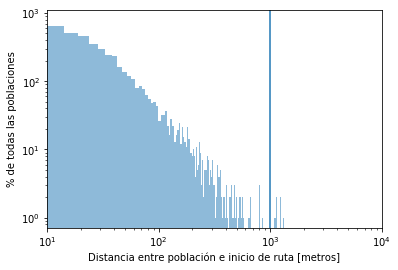

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
lugares['salto'].plot.hist(alpha=0.5,logy=True,logx=True,bins=500,xlim=[10,1e4],cumulative=False,density=False)
plt.ylabel('% de todas las poblaciones')
plt.xlabel('Distancia entre población e inicio de ruta [metros]')
plt.axvline(x=1e3)
plt.show()

In [13]:
gran_salto=lugares[lugares['salto']>1e3].sort_values(by='salto',ascending=False)
print("%i poblaciones están a más de 1km de la carretera más cercana, y suman %i personas"%
     (gran_salto['NOMBRE'].count(),gran_salto['POBLACION'].sum()))
gran_salto[['NOMBRE',"POBLACION",'salto','lat','lon']]

26 poblaciones están a más de 1km de la carretera más cercana, y suman 184 personas


,NOMBRE,POBLACION,salto,lat,lon
CODIGOINE,,,,,
33008030100,Bulnes,21,2365.403680,43.235229,-4.819731
33037092000,La Llinar,1,2241.995468,43.213773,-4.550015
33073090100,Beisap?a,1,2056.041993,43.332901,-6.640839
33001120100,Aguanes,4,1470.619159,43.155599,-6.767935
33034110100,La Candanosa,2,1331.340804,43.518880,-6.356475
33073110200,Ceceda,10,1325.316427,43.341739,-6.592704
33030021000,Rozaflor,1,1312.516054,43.477215,-5.974111
33041070900,Buenavista,25,1293.111548,43.570603,-6.722128
33058012500,El G?espe,3,1236.652078,43.227752,-4.643895


In [14]:
%matplotlib notebook
from IPython.display import Image, HTML, display

for index,lugar in gran_salto.iterrows():
    print("%s, Salto de %3.0f metros. Población: %i"%(lugar['NOMBRE'],lugar['salto'],lugar['POBLACION']))
    lat=str(lugar['lat'])
    lon=str(lugar['lon'])
    display(Image(url="https://api.mapbox.com/styles/v1/mapbox/satellite-streets-v10/static/pin-s-a+27FF00("+
      lon+","+lat+")/"+lon+","+lat+",14/200x200?access_token=pk.eyJ1IjoiYnJ1bm9zYW4iLCJhIjoic3FUc1dJWSJ9.v0525WacYWcsHM1KtbZitg"))

Bulnes, Salto de 2365 metros. Población: 21


La Llinar, Salto de 2242 metros. Población: 1


Beisap?a, Salto de 2056 metros. Población: 1


Aguanes, Salto de 1471 metros. Población: 4


La Candanosa, Salto de 1331 metros. Población: 2


Ceceda, Salto de 1325 metros. Población: 10


Rozaflor, Salto de 1313 metros. Población: 1


Buenavista, Salto de 1293 metros. Población: 25


El G?espe, Salto de 1237 metros. Población: 3


La Fanosa, Salto de 1237 metros. Población: 10


Casandres?n, Salto de 1234 metros. Población: 22


El Mazo de Mon, Salto de 1232 metros. Población: 4


Beveraso, Salto de 1219 metros. Población: 7


La Bra?a Arriba, Salto de 1139 metros. Población: 3


Fontes, Salto de 1137 metros. Población: 9


Recorva, Salto de 1112 metros. Población: 12


Folguerua, Salto de 1111 metros. Población: 2


Fontanos, Salto de 1097 metros. Población: 4


Zreic?u, Salto de 1096 metros. Población: 1


El Yenu la Tabla, Salto de 1091 metros. Población: 4


Godina, Salto de 1086 metros. Población: 27


Rucao, Salto de 1052 metros. Población: 1


Tejidiello, Salto de 1051 metros. Población: 2


Val.linaferrera, Salto de 1050 metros. Población: 3


El Alba, Salto de 1013 metros. Población: 1


Los Tornos, Salto de 1010 metros. Población: 4


No parece que haya errores muy grandes, pero en caso de que queramos arreglar los datos, podemos modificar OSM añadiendo las carreteras que puedan faltar, y volver a descargar los datos.


---

### Accesibilidad a destino Unico: Aeropuerto de Ranon

Una vez tenemos todos los datos necesarios, y hemos comprobado su calidad, podemos emepezar a trabajar en accesibilidad. Para empezar a destinos únicos, como el aeropuerto



In [15]:
import numpy as np
server=osrm_server+"/table/v1/driving/"        
comma="%2C"
Sep="%3B"

#**********AVISO********
#El enrutador asume calles sin tráfico, ni semáforos, ni tiempo para inicio-final de ruta
#Por eso los resultados a veces parecen demasiado optimistas, sobre todo en distancias cortas
#Si se quieren resultados más exactos no hay que añadir nada, pero si no lees esta nota, probablemente
#quiere decir que es buena idea sumarles unos minutos de inicio/final y un % de buffer proposcional al tiempo
buffer=10/60.  #10 minutes, in hours
overalpenalty=1.05  #5%

batch=500
origen=[-6.031837463378906,
        43.55850077671243]
origen_nombre='aeropuerto'
lugares['t_'+origen_nombre]=-1

for i in np.arange(lugares.shape[0]/batch):
    print("Doing batch %i, [%i,%i] of %i"
          %(i,batch*i,batch*(i+1),lugares.shape[0]),end='\r')
    lugares_batch=lugares.iloc[int(batch*i):].head(n=batch)
    destinos=";".join([str(i[1])+','+str(i[0]) for i in lugares_batch[['lat','lon']].values])
    destinos_nombre=lugares_batch.index
    trail=".json?sources=0"
    fullurl= server+str(origen[0])+','+str(origen[1])+";"+destinos+trail
    response = requests.get(fullurl)
    response.raise_for_status()
    duraciones=json.loads(response.text)['durations'][0][1:]
    for i in np.arange(len(duraciones)):
        lugares.loc[[destinos_nombre[i]], ['t_'+origen_nombre]]=buffer+duraciones[i]/60./60.*overalpenalty

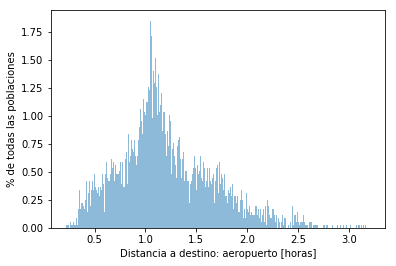

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
lugares['t_'+origen_nombre].plot.hist(alpha=0.5,bins=500,cumulative=False,density=True)
plt.ylabel('% de todas las poblaciones')
plt.xlabel('Distancia a destino: '+origen_nombre+' [horas]')
plt.show()

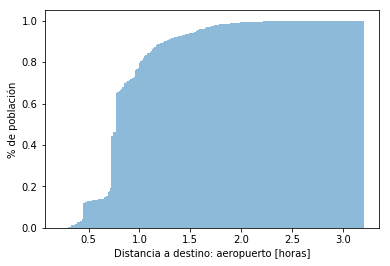

In [17]:
plt.figure()
lugares['t_'+origen_nombre].plot.hist(alpha=0.5,bins=500,cumulative=True,density=True,weights=lugares['POBLACION'])
plt.ylabel('% de población')
plt.xlabel('Distancia a destino: '+origen_nombre+' [horas]')
plt.show()

In [18]:
def weight_array(ar, weights):
     zipped = zip(ar, weights)
     weighted = []
     for i in zipped:
         for j in range(i[1]):
             weighted.append(i[0])
     return weighted


for i in np.arange(10,101,10):
    print("El %i%% de la población en Asturias tarda %2.1f horas en llegar al destino: %s"%
         (i,np.percentile(weight_array(lugares['t_aeropuerto'].values, lugares['POBLACION'].values), i),origen_nombre))

El 10% de la población en Asturias tarda 0.4 horas en llegar al destino: aeropuerto
El 20% de la población en Asturias tarda 0.7 horas en llegar al destino: aeropuerto
El 30% de la población en Asturias tarda 0.7 horas en llegar al destino: aeropuerto
El 40% de la población en Asturias tarda 0.7 horas en llegar al destino: aeropuerto
El 50% de la población en Asturias tarda 0.8 horas en llegar al destino: aeropuerto
El 60% de la población en Asturias tarda 0.8 horas en llegar al destino: aeropuerto
El 70% de la población en Asturias tarda 0.9 horas en llegar al destino: aeropuerto
El 80% de la población en Asturias tarda 1.0 horas en llegar al destino: aeropuerto
El 90% de la población en Asturias tarda 1.2 horas en llegar al destino: aeropuerto
El 100% de la población en Asturias tarda 3.2 horas en llegar al destino: aeropuerto


**¿Quién tarda 3 horas?**

In [19]:
def get_route_link(origen,destino):
    print("    http://localhost:9966/?"+
          "loc="+str(origen[1])+"%2C"+str(origen[0])+
          "&loc="+str(destino[1])+"%2C"+str(destino[0])+"&hl=en&alt=0")

In [20]:
lejos=lugares[lugares['t_aeropuerto']>3].sort_values(by='t_aeropuerto',ascending=False)

for index,lugar in lejos.head(n=5).iterrows():
    print("%i personas en %s tardan %2.1f horas en llegar al destino: %s"%
         (lugar["POBLACION"],lugar["NOMBRE"],lugar["t_"+origen_nombre],origen_nombre))
    get_route_link(origen,[lugar['lon'],lugar['lat']])

4 personas en Vilarello tardan 3.2 horas en llegar al destino: aeropuerto
    http://localhost:9966/?loc=43.55850077671243%2C-6.031837463378906&loc=43.00221427%2C-6.97056979&hl=en&alt=0
7 personas en Folgueiras Os Coutos tardan 3.2 horas en llegar al destino: aeropuerto
    http://localhost:9966/?loc=43.55850077671243%2C-6.031837463378906&loc=43.0124383%2C-6.98503161&hl=en&alt=0
4 personas en Parada tardan 3.1 horas en llegar al destino: aeropuerto
    http://localhost:9966/?loc=43.55850077671243%2C-6.031837463378906&loc=43.00767956%2C-6.96951865&hl=en&alt=0
22 personas en Valdeferreiros tardan 3.1 horas en llegar al destino: aeropuerto
    http://localhost:9966/?loc=43.55850077671243%2C-6.031837463378906&loc=43.02965885%2C-6.98062634&hl=en&alt=0
5 personas en Lagua tardan 3.1 horas en llegar al destino: aeropuerto
    http://localhost:9966/?loc=43.55850077671243%2C-6.031837463378906&loc=43.02120069%2C-6.98762902&hl=en&alt=0


Tiene Sentido

![](Vilarello.png)

---

### Accesibilidad a tipo de servicio, por ejemplo hospitales


No conozco una forma de descargar la ubicación de todos los hospitales desde una fuente oficial. [El Ministerio de Sanidad tiene un listado completo](https://www.msssi.gob.es/ciudadanos/centrosCA.do), pero con la dirección en texto, no en latitud, longitud. 

Para este ejemplo usaré los hospitales en OSM ([`amenity=hospital`](https://overpass-turbo.eu/s/xuR)).

[![](hospitales.png)](https://gist.github.com/brunosan/522c6b59fb24b5519e7a24ecafd9df33)



In [21]:
import geopandas as gpd

fname = "./data/hospitales.geojson"

df = gpd.read_file(fname)

df['lon']=df.geometry.centroid.x
df['lat']=df.geometry.centroid.y
df['nombre']=df['name'].fillna(df['name_2']) #El nombre esta inconsistentemente en dos campos
hospitales=df[['nombre','lon','lat']]
hospitales

,nombre,lon,lat
0,Hospital de la Reina,-6.593347,42.541729
1,Hospital Comarcal de Jarrio,-6.747214,43.544313
2,Hospital Universitario Central de Asturias,-5.827711,43.375914
3,Fundación Sanatorio Adaro,-5.675184,43.292282
4,Hospital de Cabueñes,-5.606329,43.524818
5,Hospital Begoña,-5.647771,43.534984
6,Hospital de Xove/Jove,-5.700581,43.549744
7,Hospital Universitario Marqués de Valdecilla,-3.829224,43.455986
8,Hospital de Liencres,-3.913785,43.463727
9,Hospital Monte Naranco,-5.872803,43.369949


Para calcular el tiempo de viaje al hospital más cercano a cada localidad, sea cual sea ese hospital, lo que hacemos es **calcular el tiempo de viajes de cada localidad a todos los hospitales**, y nos quedamos con el mínimo. Es lo mismo que es caso anterior, pero en vez de seleccionar un origen, tenemos 78 orígenes (hospitales) y 5966 poblaciones.

In [22]:
hospitales_loc=";".join([str(i[1])+','+str(i[0]) for i in hospitales[['lat','lon']].values])
hospitales_loc

'-6.593346579507576,42.541729421713626;-6.74721411951194,43.544313029578;-5.827711438032766,43.37591432161849;-5.675183694577349,43.29228213136148;-5.606329377653497,43.52481774553017;-5.647771471188361,43.53498413881249;-5.700581001732732,43.549743909072724;-3.829224344462463,43.455986408855836;-3.913785203760218,43.463726915555235;-5.872802703190238,43.36994907052286;-3.79898590175925,43.46762696149647;-5.573357048815116,42.619181382583655;-3.794460549807586,43.47723385244212;-5.567088193419536,42.600573920225;-6.61168112920684,42.553339814307726;-5.184829396488197,43.38175768410352;-5.185388965395661,43.38271093241187;-6.64369825579389,42.57225113050651;-4.076241109692409,43.362201201245696;-7.558529010699761,43.234872839363824;-7.622711731798178,43.120968815710036;-5.654685637532356,43.53856323911808;-7.359858023078266,43.65221820039209;-5.594985756607201,42.60751432236975;-7.593264622716651,43.667495253823205;-5.572353510210216,42.58999976150998;-7.601616515114259,42.9551266807805

In [23]:
server=osrm_server+"/table/v1/driving/"        
comma="%2C"
Sep="%3B"

batch=100
origen_tipo='hospital'
lugares['t_'+origen_tipo]=-1
lugares['m_'+origen_tipo]=-1

for i in np.arange(lugares.shape[0]/batch):
    print("Doing batch %i, [%i,%i] of %i"
          %(i,batch*i,batch*(i+1),lugares.shape[0]),end="\r")
    lugares_batch=lugares.iloc[int(batch*i):].head(n=batch)
    
    destinos=";".join([str(i[1])+','+str(i[0]) for i in lugares_batch[['lat','lon']].values])
    destinos_nombre=lugares_batch.index
    
    trail=".json?destinations="+\
    ';'.join([str(x) for x in np.arange(len(hospitales))])+\
    "&sources="+\
    ';'.join([str(x) for x in np.arange(len(hospitales),len(hospitales)+len(lugares_batch))])
    
    fullurl= server+hospitales_loc+";"+destinos+trail
    
    #print(fullurl)
    response = requests.get(fullurl)
    response.raise_for_status()
    duraciones_matrix=json.loads(response.text)['durations']
    duraciones=[]
    hospital_min=[]
    for origen in np.arange(np.shape(duraciones_matrix)[0]):
        duraciones+=[min(duraciones_matrix[origen])]
        hospital_min+=[np.argmin(duraciones_matrix[origen])]
    for i in np.arange(len(duraciones)):
        lugares.loc[[destinos_nombre[i]], ['t_'+origen_tipo]]=buffer+duraciones[i]/60./60.*overalpenalty
        lugares.loc[[destinos_nombre[i]], ['m_'+origen_tipo]]=hospital_min[i]

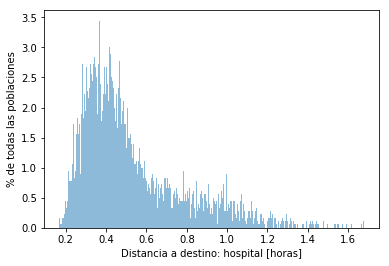

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
lugares['t_'+origen_tipo].plot.hist(alpha=0.5,bins=500,cumulative=False,density=True)
plt.ylabel('% de todas las poblaciones')
plt.xlabel('Distancia a destino: '+origen_tipo+' [horas]')
plt.show()

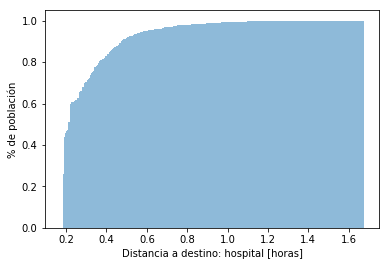

In [25]:
plt.figure()
lugares['t_'+origen_tipo].plot.hist(alpha=0.5,bins=500,cumulative=True,density=True,weights=lugares['POBLACION'])
plt.ylabel('% de población')
plt.xlabel('Distancia a destino: '+origen_tipo+' [horas]')
plt.show()

In [26]:
for i in np.arange(10,101,10):
    print("El %i%% de la población en Asturias tarda %2.1f minutos en llegar al destino: %s"%
         (i,np.percentile(weight_array(lugares['t_'+origen_tipo].values*60, lugares['POBLACION'].values), i),origen_tipo))

El 10% de la población en Asturias tarda 11.1 minutos en llegar al destino: hospital
El 20% de la población en Asturias tarda 11.1 minutos en llegar al destino: hospital
El 30% de la población en Asturias tarda 11.5 minutos en llegar al destino: hospital
El 40% de la población en Asturias tarda 11.5 minutos en llegar al destino: hospital
El 50% de la población en Asturias tarda 12.7 minutos en llegar al destino: hospital
El 60% de la población en Asturias tarda 13.5 minutos en llegar al destino: hospital
El 70% de la población en Asturias tarda 17.7 minutos en llegar al destino: hospital
El 80% de la población en Asturias tarda 21.8 minutos en llegar al destino: hospital
El 90% de la población en Asturias tarda 28.5 minutos en llegar al destino: hospital
El 100% de la población en Asturias tarda 100.6 minutos en llegar al destino: hospital


In [27]:
lejos=lugares[lugares['t_'+origen_tipo]>1].sort_values(by='t_'+origen_tipo,ascending=False)

for index,lugar in lejos.head(n=5).iterrows():
    print("%i personas en %s tardan %2.1f horas en llegar al destino: %s"%
         (lugar["POBLACION"],lugar["NOMBRE"],lugar["t_"+origen_tipo],origen_tipo))
    get_route_link([hospitales.loc[lugar['m_hospital']]['lon'],hospitales.loc[lugar['m_hospital']]['lat']],
                   [lugar['lon'],lugar['lat']])

12 personas en Alguerdo tardan 1.7 horas en llegar al destino: hospital
    http://localhost:9966/?loc=43.1658752%2C-6.5414934&loc=42.98823026%2C-6.77681246&hl=en&alt=0
4 personas en Vallimoru tardan 1.7 horas en llegar al destino: hospital
    http://localhost:9966/?loc=43.38271093241187%2C-5.185388965395661&loc=43.24054893%2C-5.25417237&hl=en&alt=0
4 personas en Vilarello tardan 1.7 horas en llegar al destino: hospital
    http://localhost:9966/?loc=43.02081534534003%2C-7.533743384784319&loc=43.00221427%2C-6.97056979&hl=en&alt=0
4 personas en Santa Comba Os Coutos tardan 1.7 horas en llegar al destino: hospital
    http://localhost:9966/?loc=43.02081534534003%2C-7.533743384784319&loc=43.01448808%2C-6.96348999&hl=en&alt=0
4 personas en Parada tardan 1.6 horas en llegar al destino: hospital
    http://localhost:9966/?loc=43.02081534534003%2C-7.533743384784319&loc=43.00767956%2C-6.96951865&hl=en&alt=0


In [28]:
lugares.to_file("data/lugares.geojson", driver="GeoJSON")

![](isocrona.png)

### Analisis de cambios

¿Qué pasa si mejoramos o empeoramos una carretera? Qué pasa si añadimos o quitamos un hospital?

Para hacer un ejemplo rápido, quitemos el hospital de Cangas de Narcea, y repitamos el estudio

In [29]:
hospitales[hospitales['nombre']=='Hospital Comarcal de Narcea']

,nombre,lon,lat
60,Hospital Comarcal de Narcea,-6.541493,43.165875


In [30]:
hospitales=hospitales[hospitales['nombre']!='Hospital Comarcal de Narcea']

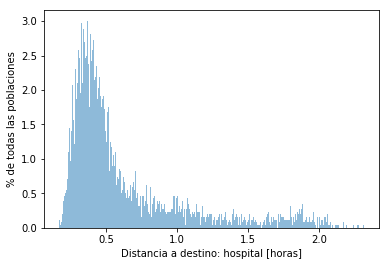

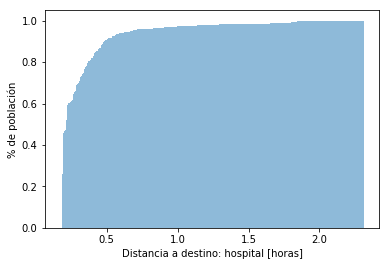

El 10% de la población en Asturias tarda 11.1 minutos en llegar al destino: hospital
El 20% de la población en Asturias tarda 11.1 minutos en llegar al destino: hospital
El 30% de la población en Asturias tarda 11.5 minutos en llegar al destino: hospital
El 40% de la población en Asturias tarda 11.5 minutos en llegar al destino: hospital
El 50% de la población en Asturias tarda 12.7 minutos en llegar al destino: hospital
El 60% de la población en Asturias tarda 13.8 minutos en llegar al destino: hospital
El 70% de la población en Asturias tarda 18.2 minutos en llegar al destino: hospital
El 80% de la población en Asturias tarda 22.1 minutos en llegar al destino: hospital
El 90% de la población en Asturias tarda 29.1 minutos en llegar al destino: hospital
El 100% de la población en Asturias tarda 138.9 minutos en llegar al destino: hospital


In [31]:
hospitales_loc=";".join([str(i[1])+','+str(i[0]) for i in hospitales[['lat','lon']].values])
server=osrm_server+"/table/v1/driving/"        
comma="%2C"
Sep="%3B"

batch=100
origen_tipo='hospital'
lugares['t_'+origen_tipo]=-1
lugares['m_'+origen_tipo]=-1

for i in np.arange(lugares.shape[0]/batch):
    print("Doing batch %i, [%i,%i] of %i"
          %(i,batch*i,batch*(i+1),lugares.shape[0]),end="\r")
    lugares_batch=lugares.iloc[int(batch*i):].head(n=batch)
    
    destinos=";".join([str(i[1])+','+str(i[0]) for i in lugares_batch[['lat','lon']].values])
    destinos_nombre=lugares_batch.index
    
    trail=".json?destinations="+\
    ';'.join([str(x) for x in np.arange(len(hospitales))])+\
    "&sources="+\
    ';'.join([str(x) for x in np.arange(len(hospitales),len(hospitales)+len(lugares_batch))])
    
    fullurl= server+hospitales_loc+";"+destinos+trail
    
    #print(fullurl)
    response = requests.get(fullurl)
    response.raise_for_status()
    duraciones_matrix=json.loads(response.text)['durations']
    duraciones=[]
    hospital_min=[]
    for origen in np.arange(np.shape(duraciones_matrix)[0]):
        duraciones+=[min(duraciones_matrix[origen])]
        hospital_min+=[np.argmin(duraciones_matrix[origen])]
    for i in np.arange(len(duraciones)):
        lugares.loc[[destinos_nombre[i]], ['t_'+origen_tipo]]=buffer+duraciones[i]/60./60.*overalpenalty
        lugares.loc[[destinos_nombre[i]], ['m_'+origen_tipo]]=hospital_min[i]
        
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
lugares['t_'+origen_tipo].plot.hist(alpha=0.5,bins=500,cumulative=False,density=True)
plt.ylabel('% de todas las poblaciones')
plt.xlabel('Distancia a destino: '+origen_tipo+' [horas]')
plt.show()
plt.figure()
lugares['t_'+origen_tipo].plot.hist(alpha=0.5,bins=500,cumulative=True,density=True,weights=lugares['POBLACION'])
plt.ylabel('% de población')
plt.xlabel('Distancia a destino: '+origen_tipo+' [horas]')
plt.show()

for i in np.arange(10,101,10):
    print("El %i%% de la población en Asturias tarda %2.1f minutos en llegar al destino: %s"%
         (i,np.percentile(weight_array(lugares['t_'+origen_tipo].values*60, lugares['POBLACION'].values), i),origen_tipo))

In [32]:
lugares.to_file("data/lugares2.geojson", driver="GeoJSON")

Con todos los hospitales:
![](isocrona.png)

---

Con el Hospital Comarcal de Narcea: 
![](isocrona2.png)

**Nótese que los porcentajes de población afectados son muy pocos, son zonas poco pobladas y muy dispersas**